In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [7]:
#import the data
store_sales=pd.read_csv('/content/sample_data/data.xls')
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2823 non-null   int64  
 1   ORDER NUMBER       2823 non-null   int64  
 2   QUANTITY ORDERED   2823 non-null   int64  
 3   PRICE EACH         2823 non-null   float64
 4   ORDER LINE NUMBER  2823 non-null   int64  
 5   SALES              2823 non-null   float64
 6   ORDER DATE         2823 non-null   object 
 7   STATUS             2823 non-null   object 
 8   QTR_ID             2823 non-null   int64  
 9   MONTH_ID           2823 non-null   int64  
 10  YEAR_ID            2823 non-null   int64  
 11  PRODUCTLINE        2823 non-null   object 
 12  MSRP               2823 non-null   int64  
 13  PRODUCTCODE        2823 non-null   object 
 14  CUSTOMER NAME      2823 non-null   object 
 15  CITY               2823 non-null   object 
 16  COUNTRY            2823 

In [8]:
store_sales=store_sales.drop('Unnamed: 0',axis=1)

In [9]:
store_sales.head()

,ORDER NUMBER,QUANTITY ORDERED,PRICE EACH,ORDER LINE NUMBER,SALES,ORDER DATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMER NAME,CITY,COUNTRY,TERRITORY,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,NYC,USA,AMER,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,Reims,France,EMEA,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,Paris,France,EMEA,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,Pasadena,USA,AMER,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,San Francisco,USA,AMER,Medium


In [10]:
store_sales=store_sales[['ORDER DATE','SALES']] # we just need the date and sales to predict values

In [11]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ORDER DATE  2823 non-null   object 
 1   SALES       2823 non-null   float64
dtypes: float64(1), object(1)
memory usage: 44.2+ KB


In [12]:
store_sales['ORDER DATE']=pd.to_datetime(store_sales['ORDER DATE']) #converting date to datetime format
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ORDER DATE  2823 non-null   datetime64[ns]
 1   SALES       2823 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 44.2 KB


In [13]:
store_sales=store_sales.set_index('ORDER DATE')

In [14]:
store_sales.head()#data starting

,SALES
ORDER DATE,
2003-02-24,2871.00
2003-05-07,2765.90
2003-07-01,3884.34
2003-08-25,3746.70
2003-10-10,5205.27


In [15]:
store_sales.tail()#ending date

,SALES
ORDER DATE,
2004-12-02,2244.40
2005-01-31,3978.51
2005-03-01,5417.57
2005-03-28,2116.16
2005-05-06,3079.44


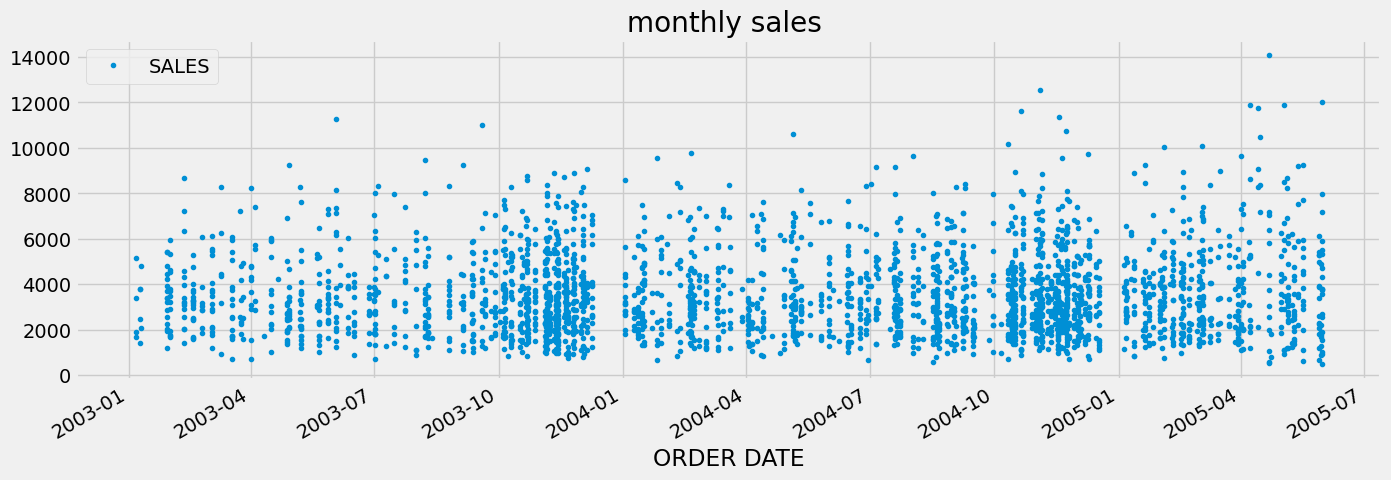

In [16]:
store_sales.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='monthly sales ')
plt.show()

<Axes: ylabel='Frequency'>

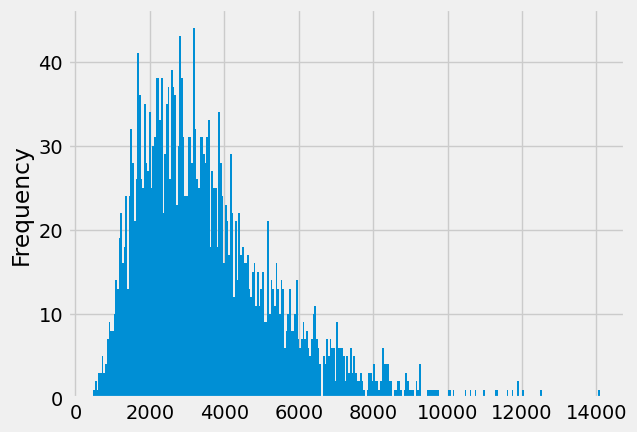

In [17]:
#finding outliers
store_sales['SALES'].plot(kind='hist', bins=300)



In [18]:
store_sales.query('SALES > 8_000')

,SALES
ORDER DATE,
2003-09-19,10993.50
2003-11-06,8014.82
2003-12-05,9064.89
2004-08-17,8014.82
2004-10-11,10172.70
...,...
2004-11-05,8844.12
2004-11-05,8209.44
2005-03-17,8977.05


<Axes: title={'center': 'Outliers'}, xlabel='ORDER DATE'>

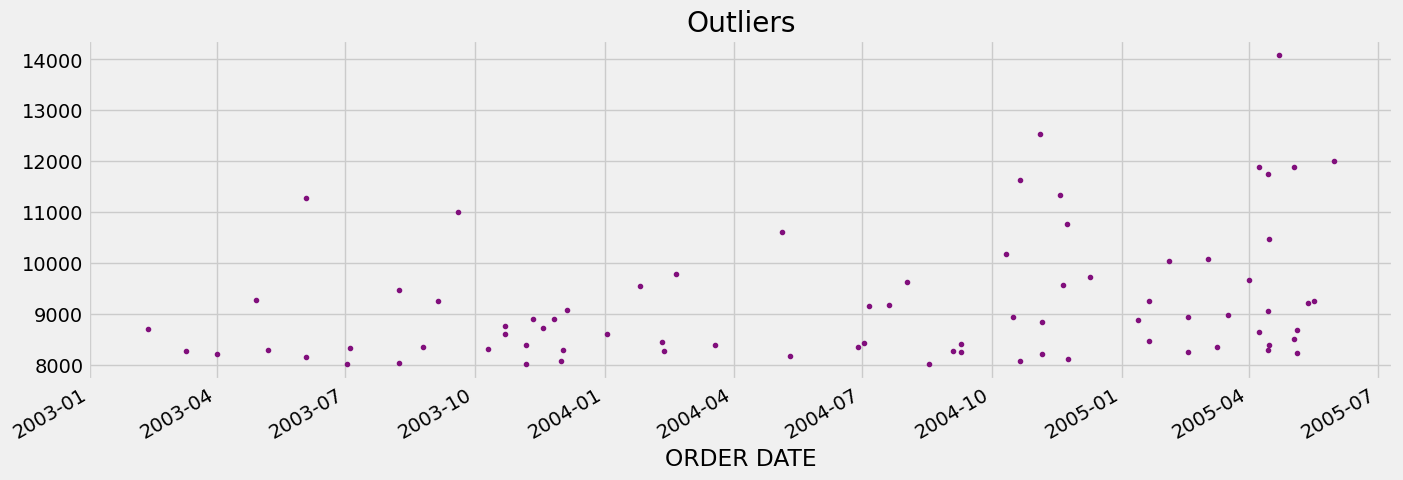

In [19]:
store_sales.query('SALES > 8_000')['SALES'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')



In [20]:
#Removing outliers
store_sales = store_sales.query('SALES < 8_000').copy()
store_sales

,SALES
ORDER DATE,
2003-02-24,2871.00
2003-05-07,2765.90
2003-07-01,3884.34
2003-08-25,3746.70
2003-10-10,5205.27
...,...
2004-12-02,2244.40
2005-01-31,3978.51
2005-03-01,5417.57


##Train/Test split

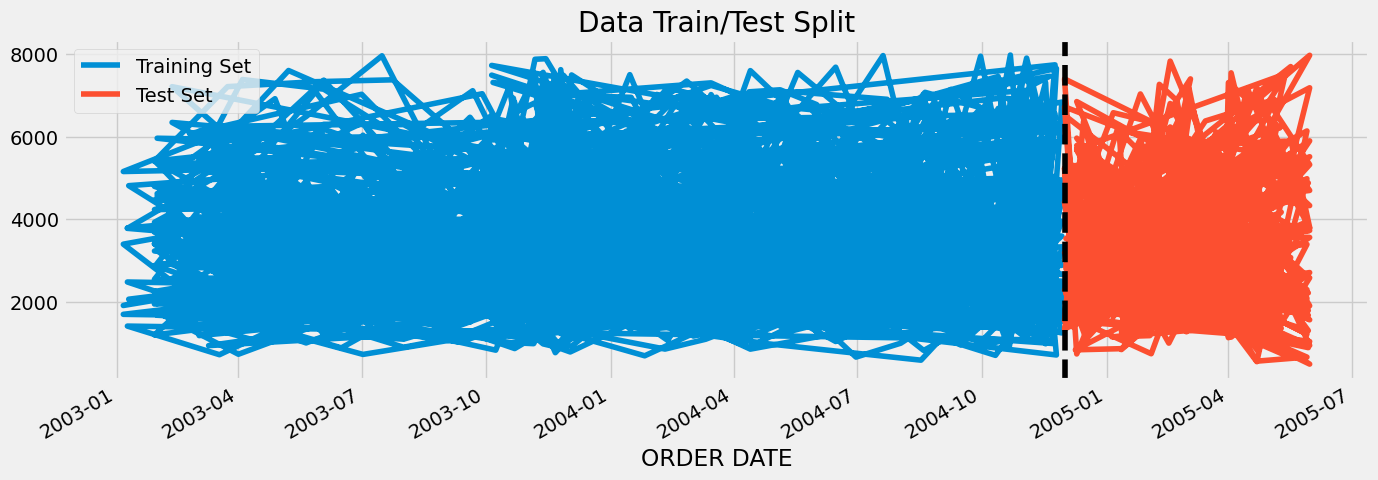

In [21]:
train = store_sales.loc[store_sales.index < '12-01-2004']
test = store_sales.loc[store_sales.index >= '12-01-2004']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('12-01-2004', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

##Time series cross validation

In [22]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=30*5, gap=2)
store_sales=store_sales.sort_index()



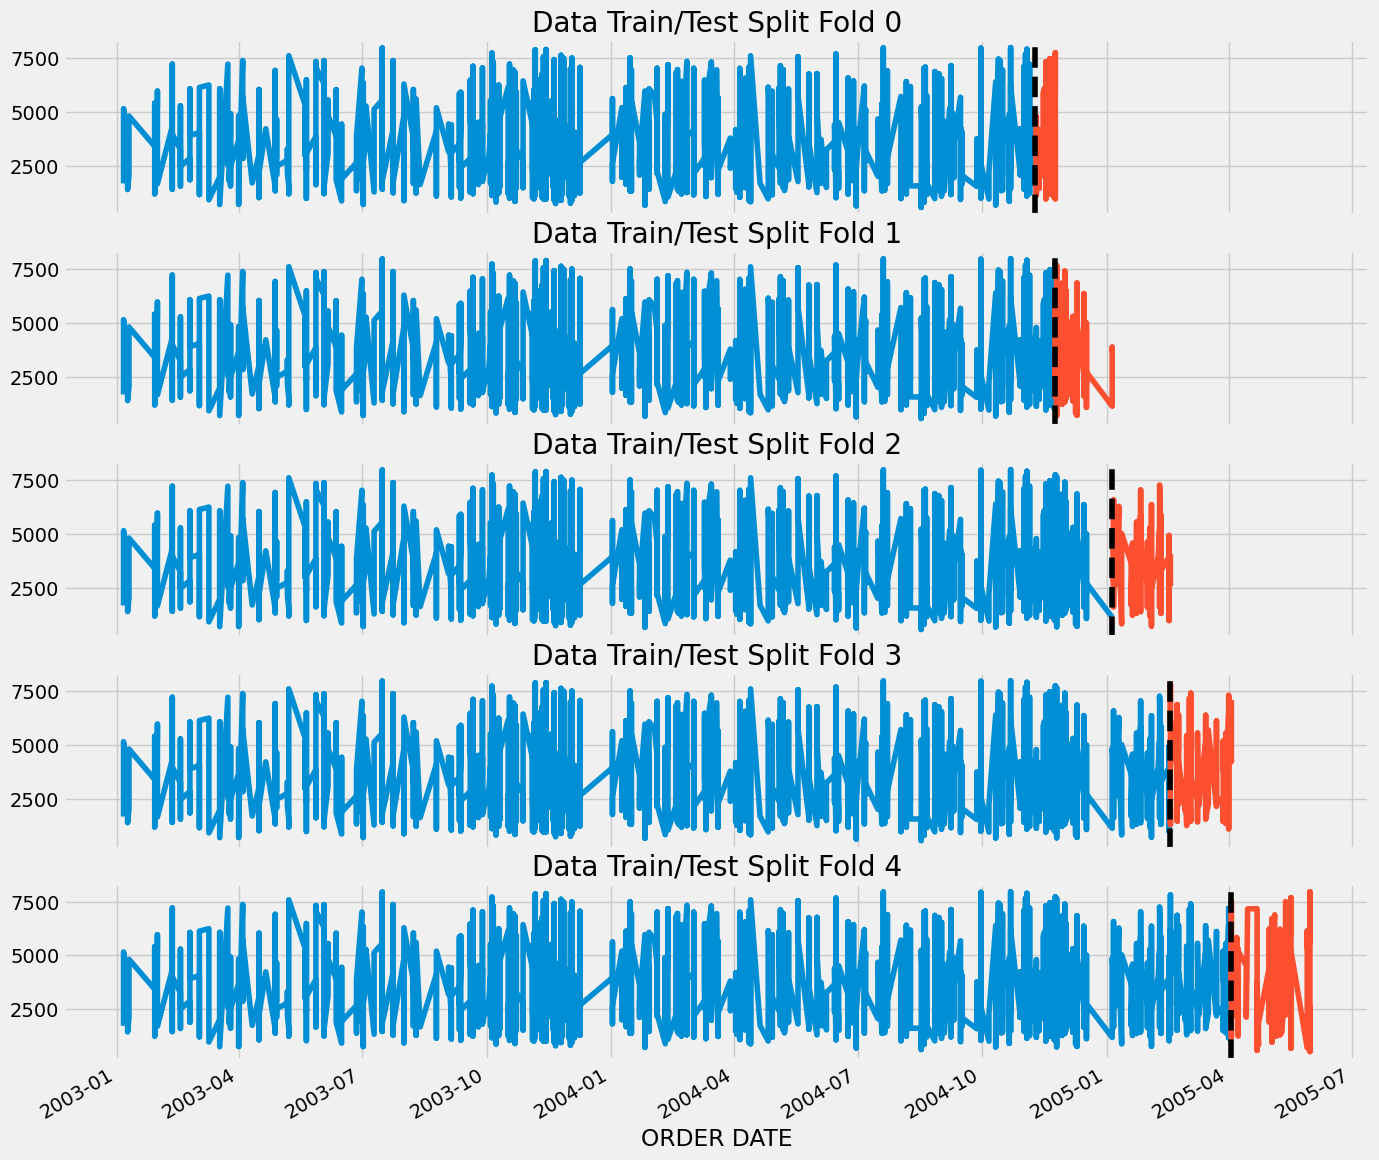

In [23]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(store_sales):
    train = store_sales.iloc[train_idx]

    test = store_sales.iloc[val_idx]
    train['SALES'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['SALES'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()



##Forecasting explain

In [24]:
train.shape

(2592, 1)

In [25]:
test.shape

(150, 1)

##Feature creation

In [26]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(store_sales)
df


,SALES,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
ORDER DATE,,,,,,,,
2003-01-06,1689.03,0,1,1,2003,6,6,2
2003-01-06,3390.00,0,1,1,2003,6,6,2
2003-01-06,1903.22,0,1,1,2003,6,6,2
2003-01-06,5151.00,0,1,1,2003,6,6,2
2003-01-09,3782.00,3,1,1,2003,9,9,2
...,...,...,...,...,...,...,...,...
2005-05-31,7969.36,1,2,5,2005,151,31,22
2005-05-31,3553.88,1,2,5,2005,151,31,22
2005-05-31,1030.44,1,2,5,2005,151,31,22


In [27]:
def add_lags(df):
    target_map = df['SALES'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    return df



In [28]:
store_sales = add_lags(store_sales)


In [29]:
store_sales.head()

,SALES,lag1,lag2,lag3
ORDER DATE,,,,
2003-01-06,1689.03,NaN,NaN,NaN
2003-01-06,3390.00,NaN,NaN,NaN
2003-01-06,1903.22,NaN,NaN,NaN
2003-01-06,5151.00,NaN,NaN,NaN
2003-01-09,3782.00,NaN,NaN,NaN


In [30]:
store_sales.tail()

,SALES,lag1,lag2,lag3
ORDER DATE,,,,
2005-05-31,7969.36,4140.23,7307.42,4175.6
2005-05-31,3553.88,4140.23,7307.42,4175.6
2005-05-31,1030.44,4140.23,7307.42,4175.6
2005-05-31,5318.04,4140.23,7307.42,4175.6
2005-05-31,5510.54,4140.23,7307.42,4175.6


In [31]:
tss = TimeSeriesSplit(n_splits=5, test_size=30*5, gap=2)
store_sales = store_sales.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(store_sales):
    train = store_sales.iloc[train_idx]
    test = store_sales.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'SALES'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:3704.85658	validation_1-rmse:3677.28209


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:09:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1991.98527	validation_1-rmse:1967.76376
[200]	validation_0-rmse:1623.99073	validation_1-rmse:1599.45498
[300]	validation_0-rmse:1564.31845	validation_1-rmse:1541.90413
[400]	validation_0-rmse:1554.02015	validation_1-rmse:1531.32734
[500]	validation_0-rmse:1550.75030	validation_1-rmse:1530.80086
[529]	validation_0-rmse:1550.06157	validation_1-rmse:1531.28082
[0]	validation_0-rmse:3701.78200	validation_1-rmse:3632.65602
[100]	validation_0-rmse:1989.57837	validation_1-rmse:1879.55835
[200]	validation_0-rmse:1622.66917	validation_1-rmse:1533.21088


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:09:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1563.88821	validation_1-rmse:1492.77184
[398]	validation_0-rmse:1553.52909	validation_1-rmse:1492.58239
[0]	validation_0-rmse:3698.13839	validation_1-rmse:3628.73364
[100]	validation_0-rmse:1985.34872	validation_1-rmse:2393.37313
[200]	validation_0-rmse:1618.30727	validation_1-rmse:1845.14873


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:09:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1559.35364	validation_1-rmse:1680.43157
[400]	validation_0-rmse:1548.45576	validation_1-rmse:1625.64347
[500]	validation_0-rmse:1544.28655	validation_1-rmse:1613.00525
[600]	validation_0-rmse:1541.32551	validation_1-rmse:1610.83286
[616]	validation_0-rmse:1540.87869	validation_1-rmse:1610.69142
[0]	validation_0-rmse:3692.63099	validation_1-rmse:3806.74243
[100]	validation_0-rmse:1977.27908	validation_1-rmse:2111.58315
[200]	validation_0-rmse:1608.79595	validation_1-rmse:1745.61123


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:09:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1548.59441	validation_1-rmse:1676.81029
[400]	validation_0-rmse:1536.35163	validation_1-rmse:1661.89546
[500]	validation_0-rmse:1532.23882	validation_1-rmse:1658.04450
[599]	validation_0-rmse:1529.73944	validation_1-rmse:1658.12803
[0]	validation_0-rmse:3697.01190	validation_1-rmse:3902.18808
[100]	validation_0-rmse:1982.08479	validation_1-rmse:2280.06706
[200]	validation_0-rmse:1613.99548	validation_1-rmse:1940.67768


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:09:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:1554.07686	validation_1-rmse:1876.54805
[400]	validation_0-rmse:1542.48403	validation_1-rmse:1863.69649
[500]	validation_0-rmse:1538.29317	validation_1-rmse:1860.50316
[580]	validation_0-rmse:1535.45008	validation_1-rmse:1860.92708


In [32]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')



Score across folds 1629.8686
Fold scores:[1530.2524820452513, 1490.7094921941891, 1610.6045140731378, 1657.5608952496189, 1860.2156056145238]


In [33]:
# Retrain on all data
store_sales = create_features(store_sales)

FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'SALES'

X_all = store_sales[FEATURES]
y_all = store_sales[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=True)

[0]	validation_0-rmse:3710.40419
[1]	validation_0-rmse:3680.06126
[2]	validation_0-rmse:3650.07662
[3]	validation_0-rmse:3620.44710
[4]	validation_0-rmse:3591.16929
[5]	validation_0-rmse:3562.24011
[6]	validation_0-rmse:3533.65602
[7]	validation_0-rmse:3505.41398
[8]	validation_0-rmse:3477.51039
[9]	validation_0-rmse:3449.94282
[10]	validation_0-rmse:3422.70739
[11]	validation_0-rmse:3395.79139
[12]	validation_0-rmse:3369.21116
[13]	validation_0-rmse:3342.94426
[14]	validation_0-rmse:3317.00683
[15]	validation_0-rmse:3291.37707
[16]	validation_0-rmse:3266.06128
[17]	validation_0-rmse:3241.06568
[18]	validation_0-rmse:3216.36892
[19]	validation_0-rmse:3191.98667
[20]	validation_0-rmse:3167.89745
[21]	validation_0-rmse:3144.11687
[22]	validation_0-rmse:3120.62374
[23]	validation_0-rmse:3097.42485
[24]	validation_0-rmse:3074.52510
[25]	validation_0-rmse:3051.91376
[26]	validation_0-rmse:3029.57915
[27]	validation_0-rmse:3007.53568
[28]	validation_0-rmse:2985.76404
[29]	validation_0-rmse:2

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [15:09:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[33]	validation_0-rmse:2881.03650
[34]	validation_0-rmse:2860.89350
[35]	validation_0-rmse:2841.01536
[36]	validation_0-rmse:2821.39273
[37]	validation_0-rmse:2802.02158
[38]	validation_0-rmse:2782.91235
[39]	validation_0-rmse:2764.05450
[40]	validation_0-rmse:2745.44558
[41]	validation_0-rmse:2727.07443
[42]	validation_0-rmse:2708.95185
[43]	validation_0-rmse:2691.07445
[44]	validation_0-rmse:2673.42766
[45]	validation_0-rmse:2656.01432
[46]	validation_0-rmse:2638.84659
[47]	validation_0-rmse:2621.91083
[48]	validation_0-rmse:2605.19579
[49]	validation_0-rmse:2588.71655
[50]	validation_0-rmse:2572.45351
[51]	validation_0-rmse:2556.40936
[52]	validation_0-rmse:2540.59756
[53]	validation_0-rmse:2524.99134
[54]	validation_0-rmse:2509.61310
[55]	validation_0-rmse:2494.44813
[56]	validation_0-rmse:2479.48503
[57]	validation_0-rmse:2464.74026
[58]	validation_0-rmse:2450.18929
[59]	validation_0-rmse:2435.84618
[60]	validation_0-rmse:2421.71453
[61]	validation_0-rmse:2407.78316
[62]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [34]:
df.index.max() #Getting the maximum date in data

Timestamp('2005-05-31 00:00:00')

In [36]:
# Create future dataframe
future = pd.date_range('2005-05-31','2005-08-31')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)



In [37]:
df_and_future.head()

,SALES,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture,lag1,lag2,lag3
2003-01-06,1689.03,0,1,1,2003,6,6,2,False,NaN,NaN,NaN
2003-01-06,3390.00,0,1,1,2003,6,6,2,False,NaN,NaN,NaN
2003-01-06,1903.22,0,1,1,2003,6,6,2,False,NaN,NaN,NaN
2003-01-06,5151.00,0,1,1,2003,6,6,2,False,NaN,NaN,NaN
2003-01-09,3782.00,3,1,1,2003,9,9,2,False,NaN,NaN,NaN


In [38]:
future_w_features = df_and_future.query('isFuture').copy()

In [39]:
future_w_features

,SALES,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,isFuture,lag1,lag2,lag3
2005-05-31,NaN,1,2,5,2005,151,31,22,True,4140.23,7307.42,4175.60
2005-06-01,NaN,2,2,6,2005,152,1,22,True,NaN,NaN,5243.79
2005-06-02,NaN,3,2,6,2005,153,2,22,True,5498.08,1979.60,3491.18
2005-06-03,NaN,4,2,6,2005,154,3,22,True,NaN,NaN,NaN
2005-06-04,NaN,5,2,6,2005,155,4,22,True,3387.78,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2005-08-27,NaN,5,3,8,2005,239,27,34,True,NaN,NaN,5433.75
2005-08-28,NaN,6,3,8,2005,240,28,34,True,NaN,NaN,1875.09
2005-08-29,NaN,0,3,8,2005,241,29,35,True,NaN,NaN,NaN
2005-08-30,NaN,1,3,8,2005,242,30,35,True,NaN,NaN,NaN


##predict The Future

In [40]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [43]:
future_w_features['pred']

,pred
2005-05-31,3623.375732
2005-06-01,3427.948242
2005-06-02,2294.376709
2005-06-03,3370.037598
2005-06-04,3374.117920
...,...
2005-08-27,2998.109619
2005-08-28,3569.734375
2005-08-29,3350.354248
2005-08-30,3346.487793


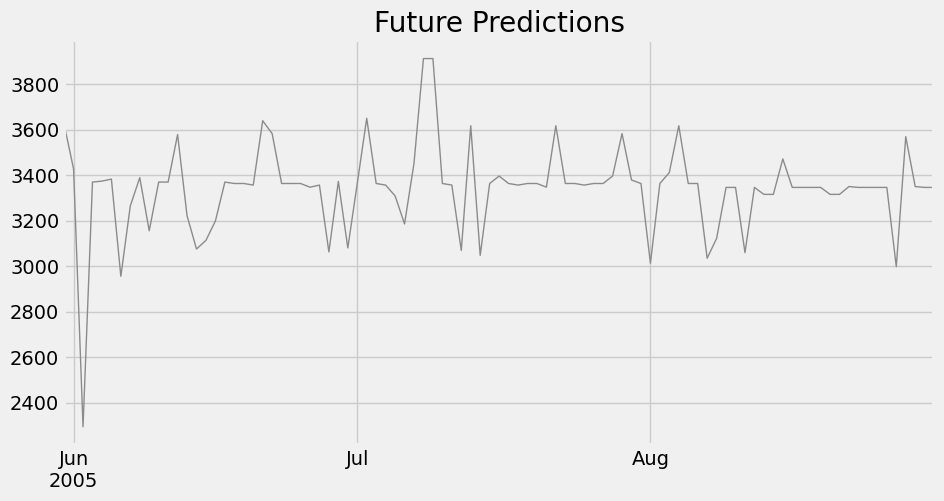

In [48]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

##Forecast Test

In [49]:
test

,SALES,lag1,lag2,lag3,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
ORDER DATE,,,,,,,,,,,
2005-04-03,3843.20,3491.18,3834.38,NaN,6,2,4,2005,93,3,13
2005-04-03,4992.61,3491.18,3834.38,NaN,6,2,4,2005,93,3,13
2005-04-03,7543.75,3491.18,3834.38,NaN,6,2,4,2005,93,3,13
2005-04-03,2031.40,3491.18,3834.38,NaN,6,2,4,2005,93,3,13
2005-04-03,3659.02,3491.18,3834.38,NaN,6,2,4,2005,93,3,13
...,...,...,...,...,...,...,...,...,...,...,...
2005-05-31,7969.36,4140.23,7307.42,4175.6,1,2,5,2005,151,31,22
2005-05-31,3553.88,4140.23,7307.42,4175.6,1,2,5,2005,151,31,22
2005-05-31,1030.44,4140.23,7307.42,4175.6,1,2,5,2005,151,31,22


In [50]:
test['prediction'] = reg.predict(X_test)
store_sales = store_sales.merge(test[['prediction']], how='left', left_index=True, right_index=True)

store_sales


,SALES,lag1,lag2,lag3,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
ORDER DATE,,,,,,,,,,,,
2003-01-06,1689.03,NaN,NaN,NaN,0,1,1,2003,6,6,2,NaN
2003-01-06,3390.00,NaN,NaN,NaN,0,1,1,2003,6,6,2,NaN
2003-01-06,1903.22,NaN,NaN,NaN,0,1,1,2003,6,6,2,NaN
2003-01-06,5151.00,NaN,NaN,NaN,0,1,1,2003,6,6,2,NaN
2003-01-09,3782.00,NaN,NaN,NaN,3,1,1,2003,9,9,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-31,5510.54,4140.23,7307.42,4175.6,1,2,5,2005,151,31,22,3623.375732
2005-05-31,5510.54,4140.23,7307.42,4175.6,1,2,5,2005,151,31,22,3623.375732
2005-05-31,5510.54,4140.23,7307.42,4175.6,1,2,5,2005,151,31,22,3623.375732


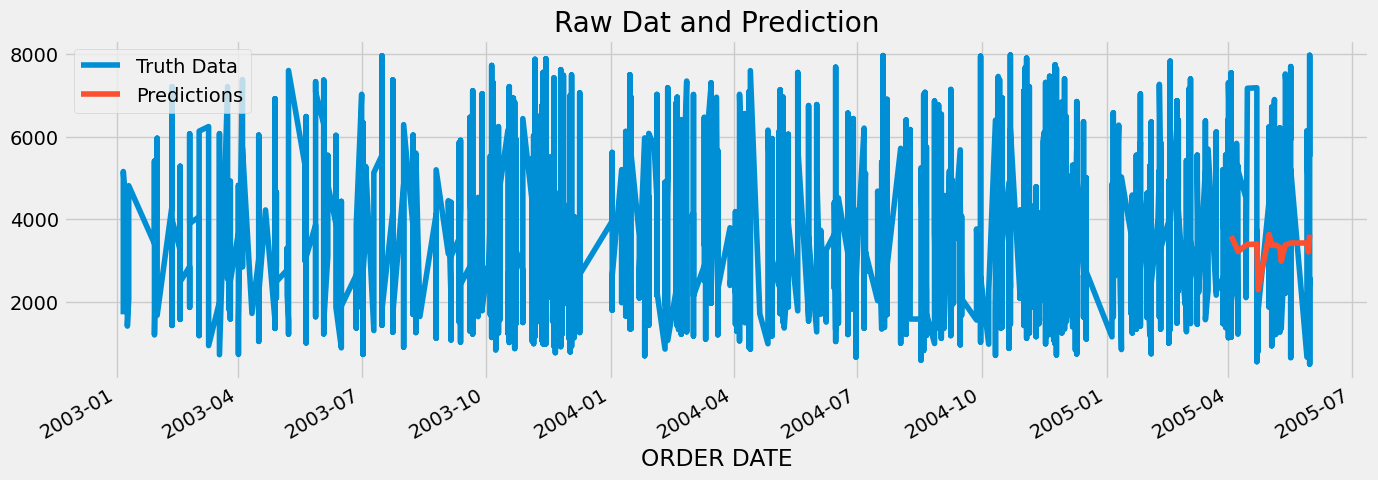

In [51]:
ax = store_sales[['SALES']].plot(figsize=(15, 5))
store_sales['prediction'].plot(ax=ax)
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [52]:
score = np.sqrt(mean_squared_error(test['SALES'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1823.65


##Calculate Error

In [53]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

,error
date,
2005-04-15,3788.193818
2005-04-22,2068.376667
2005-05-03,1831.978067
2005-05-31,1678.201030
2005-05-13,1617.733441
2005-05-17,1612.238650
2005-05-30,1594.739662
2005-05-09,1594.721258
2005-04-07,1544.050505


In [54]:
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

,error
date,
2005-05-06,970.710028
2005-04-23,989.129189
2005-05-10,1100.536867
2005-05-01,1111.735933
2005-04-14,1207.400000
2005-04-03,1449.996000
2005-05-05,1458.785000
2005-05-29,1470.961170
2005-04-08,1473.863089
